In [217]:
import idx2numpy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from keras.optimizers import Adam, Nadam
from keras.activations import softmax, relu, elu, sigmoid
from keras.losses import categorical_crossentropy, logcosh
import talos as ta
from talos import live
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [130]:
def read_data():
    train_images = idx2numpy.convert_from_file('train-images.idx3-ubyte')
    train_labels = idx2numpy.convert_from_file('train-labels.idx1-ubyte')
    test_images = idx2numpy.convert_from_file('t10k-images.idx3-ubyte')
    test_labels = idx2numpy.convert_from_file('t10k-labels.idx1-ubyte')
    return train_images,train_labels,test_images,test_labels

In [131]:
def preprocessing(images,labels):
    rows,cols = 28,28
    number_class_labels = len(np.unique(labels))
    images = images.reshape(images.shape[0], rows, cols, 1)
    images = images.astype('float32')
    images /= 255
    labels = to_categorical(labels, number_class_labels)
    return images,labels

In [132]:
train_images_all,train_labels_all,test_images_all,test_labels_all = read_data()
train_image_pr, train_label_pr = preprocessing(train_images_all,train_labels_all)
test_images, test_labels = preprocessing(test_images_all,test_labels_all)
train_images, val_images, train_labels, val_labels = train_test_split(train_image_pr, train_label_pr, test_size=0.2, 
                                                                      random_state=1)

In [146]:
def cnn_model_after_tuning(train_images,train_labels,val_images,val_labels, params):
    classifier_model = Sequential()
    classifier_model.add(Convolution2D(32,(3,3), input_shape = (28,28,1),activation = params['activation']))
    classifier_model.add(MaxPooling2D(pool_size = (2,2),strides = 2))
    classifier_model.add(Dropout(params['dropout']))
    classifier_model.add(Flatten())
    classifier_model.add(Dense(units = 128, activation = params['activation']))
    classifier_model.add(Dropout(params['dropout']))
    classifier_model.add(Dense(units = 10, activation = params['last_activation']))
    classifier_model.compile(loss=params['losses'],
                  optimizer=params['optimizer'](),
                  metrics=['acc'])
    history = classifier_model.fit(
                        train_images,train_labels,
                        validation_data=[val_images, val_labels],
                        batch_size=params['batch_size'],
                        callbacks=[live()],
                        epochs=params['epochs'],
                        verbose=0)
    return history,classifier_model

In [147]:
parameters = {
     'batch_size': (30,50,60),
     'epochs': (5,10,20),
     'dropout': (0,0.25,0.5),
     'optimizer': [Nadam, Adam],
     'losses': [categorical_crossentropy,logcosh],
     'activation':[relu, elu],
     'last_activation': [softmax,sigmoid]
    }

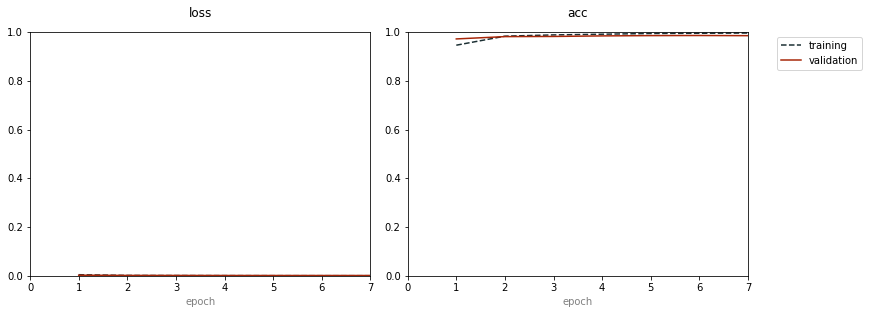


































100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [49:54<00:00, 201.08s/it]


































Scan Finished!


In [154]:
t = ta.Scan(x=train_images,
            y=train_labels,
            x_val=val_images,
            y_val=val_labels,
            model=cnn_model_after_tuning,
            params=parameters,
            grid_downsample=0.01,
            print_params = True)
                        

In [199]:
print("Scan Summary Details")
t.details

Scan Summary Details


In [200]:
#("The hyper-parameters selected in each iteration and their train and val accuracies")
r = ta.Reporting(t)
r.data.head()

,round_epochs,val_loss,val_acc,loss,acc,batch_size,epochs,dropout,optimizer,losses,activation,last_activation,nan
1,9,0.08697739338418463,0.9820000068346659,0.009354746603607396,0.9978958352903525,40,9,0.0,<class 'keras.optimizers.Adam'>,<function categorical_crossentropy at 0x000001...,<function elu at 0x00000195D57812F0>,<function softmax at 0x00000195D5781268>,0
2,7,0.0766620033026993,0.9818333409229915,0.014351068318734785,0.9949791703621547,40,7,0.0,<class 'keras.optimizers.Adam'>,<function categorical_crossentropy at 0x000001...,<function elu at 0x00000195D57812F0>,<function sigmoid at 0x00000195D5781620>,1
3,7,0.001634645675649425,0.979000004529953,0.0007155206014695314,0.990645837366581,48,7,0.0,<class 'keras.optimizers.Nadam'>,<function logcosh at 0x00000195D57546A8>,<function elu at 0x00000195D57812F0>,<function softmax at 0x00000195D5781268>,2
4,6,0.0013722561323442262,0.983583334311843,0.0005234579323401689,0.9926041671074927,39,6,0.0,<class 'keras.optimizers.Nadam'>,<function logcosh at 0x00000195D57546A8>,<function relu at 0x00000195D5781510>,<function softmax at 0x00000195D5781268>,3
5,7,0.001221853429243575,0.9844166719118754,0.0003789444809293639,0.9950625035613775,44,7,0.0,<class 'keras.optimizers.Nadam'>,<function logcosh at 0x00000195D57546A8>,<function relu at 0x00000195D5781510>,<function softmax at 0x00000195D5781268>,4


In [178]:
print("Number of iterations during scanning")
r.rounds()

Number of iterations during scanning


16

In [182]:
print("Highest validation accuracy")
r.high()

Highest validation accuracy


'0.9867500058611234'

In [183]:
# returns the number of rounds it took to find best model
r.rounds2high()

11

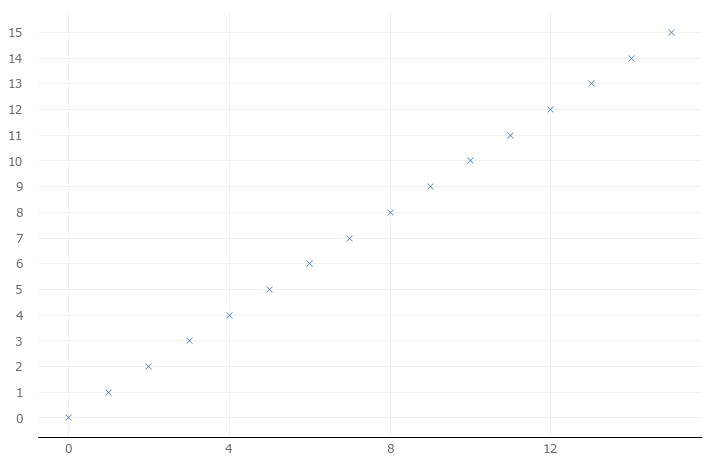

In [186]:
# a regression plot for two dimensions 
r.plot_regs()

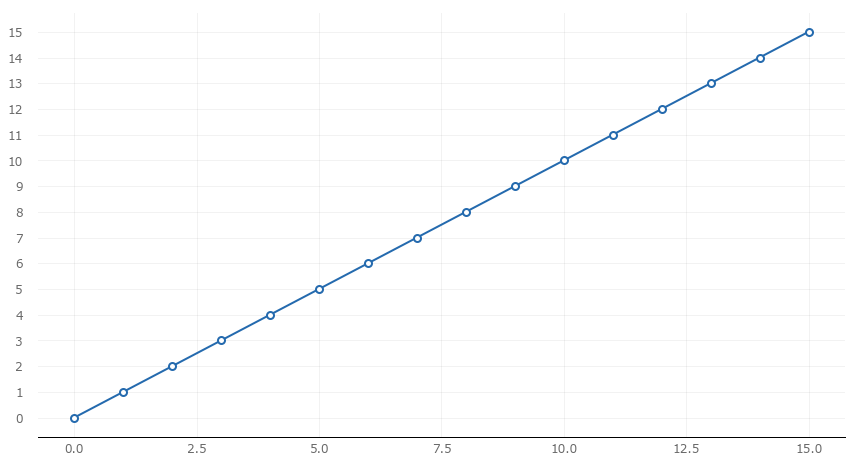

In [187]:
# line plot
r.plot_line()

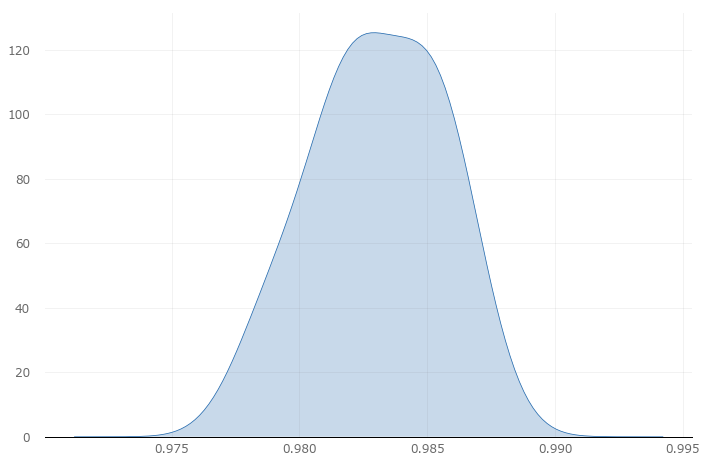

In [188]:
# up to two dimensional kernel density estimator
r.plot_kde('val_acc')

In [215]:
p = ta.Predict(t)
predicted_test_labels = p.predict_classes(test_images)

In [219]:
accuracy_score(test_labels_all,predicted_test_labels)

0.9861

In [229]:
e = ta.Evaluate(t)
e.evaluate(train_images, train_labels, folds=10, average='macro')

99.51% (+/- 0.08%)
